# 1. Очистка и подготовка данных

**Цель:** трансформировать исходный датасет в качественную базу для дальнейшего анализа и проверки гипотез.

**Этапы:**
- импорт данных и первичный осмотр;
- приведение данных к корректным типам;
- проверка на дубликаты и пропуски;
- создание новых признаков;
- удаление аномалий и выбросов;
- проверка данных на соответствие бизнес-логике;
- экспорт очищенного датасета.

---

### Импорт данных и первичный осмотр

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

PATH_RAW = '../data/raw/kicksharing.csv'
PATH_CLEAN = '../data/clean'

In [2]:
sns.set_theme(style='darkgrid', palette='deep')

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.precision', 3)

In [3]:
df = pd.read_csv(PATH_RAW)

In [4]:
# потребление памяти по столбцам (в байтах)
df.memory_usage(deep=True)

Index                           132
order_rk                    3173992
party_rk                    3173992
gender_cd                  19784872
age                         3173992
education_level_cd         16497148
marital_status_cd          17050548
lvn_state_nm               34998359
minute_cost                 3173992
activation_cost             3173992
hold_amount                 3173992
transport_model            20319570
distance_km                 3173992
created_dttm               29756175
book_start_dttm            29756175
book_end_dttm              29756175
book_time_zone_cd           3173992
local_book_start_dttm      29756175
nominal_price_rub_amt       3173992
loyalty_accrual_rub_amt     3173992
loyalty_accrual_bns_amt     3173992
dtype: int64

In [5]:
# общее потребление памяти (в Мб)
df.memory_usage(deep=True).sum() / (2 ** 20)

np.float64(250.42461490631104)

Посмотрим на данные:

In [6]:
df.head()

,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,transport_model,distance_km,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt
0,266071307,761067705,M,40,UGR,DIV,ТЮМЕНСКАЯ ОБЛ,4.99,30.0,300.0,SL,3.690,2024-08-07 09:47:25.000000,2024-08-07 09:47:29.325252,2024-08-07 10:07:59.339524,5,2024-08-07 11:47:29.325252,134.79,19.48,NaN
1,355113920,614049469,F,30,GRD,MAR,РОСТОВСКАЯ ОБЛ,8.49,50.0,300.0,SL,1.115,2024-10-17 14:57:20.000000,2024-10-17 14:57:24.586000,2024-10-17 15:04:19.419607,3,2024-10-17 14:57:24.586000,109.43,40.30,NaN
2,347424551,757583701,M,28,UGR,UNM,СВЕРДЛОВСКАЯ ОБЛ,5.99,30.0,300.0,E,1.516,2024-09-19 05:31:41.000000,2024-09-19 05:34:59.476000,2024-09-19 05:41:50.164372,5,2024-09-19 07:34:59.476000,71.93,10.79,NaN
3,351562959,541367366,M,24,GRD,UNM,Г МОСКВА,8.99,50.0,300.0,SL,0.499,2024-10-04 16:05:09.000000,2024-10-04 16:05:13.162000,2024-10-04 16:07:31.724918,3,2024-10-04 16:05:13.162000,76.97,7.70,NaN
4,258647149,238473615,M,34,NaN,NaN,Г МОСКВА,6.99,50.0,300.0,SL,2.602,2024-07-10 06:57:40.000000,2024-07-10 06:57:43.017125,2024-07-10 07:07:48.446462,3,2024-07-10 06:57:43.017125,126.89,25.38,NaN


Отсортируем записи по времени начала поездки:

In [7]:
df = df.sort_values(by='book_start_dttm').reset_index(drop=True)
df.head()

,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,transport_model,distance_km,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt
0,252632665,517007040,M,26,GRD,UNM,Г МОСКВА,7.49,50.0,300.0,SL,280.129,2024-04-07 14:56:47.000000,2024-04-07 14:57:01.030814,2024-04-07 15:00:26.432310,3,2024-04-07 14:57:01.030814,79.96,NaN,NaN
1,252625610,517007040,M,26,GRD,UNM,Г МОСКВА,7.49,50.0,300.0,SL,2.120,2024-04-09 12:23:51.000000,2024-04-09 12:23:56.253700,2024-04-09 12:25:18.952234,3,2024-04-09 12:23:56.253700,64.98,NaN,NaN
2,252622551,517007040,M,26,GRD,UNM,Г МОСКВА,7.99,50.0,300.0,SL,496.838,2024-04-09 13:33:17.000000,2024-04-09 13:33:21.237110,2024-04-09 13:42:25.580416,3,2024-04-09 13:33:21.237110,129.90,1.0,NaN
3,252611448,218046530,M,37,GRD,UNM,Г МОСКВА,7.99,50.0,300.0,SL,2708.593,2024-04-09 17:49:32.000000,2024-04-09 17:49:38.672744,2024-04-09 18:06:34.975211,3,2024-04-09 17:49:38.672744,185.83,1.0,NaN
4,252626408,292629240,M,35,UGR,MAR,Г МОСКВА,7.99,50.0,300.0,SL,0.000,2024-04-10 16:41:09.000000,2024-04-10 16:41:13.265475,2024-04-10 16:43:42.462157,3,2024-04-10 16:41:13.265475,73.97,NaN,NaN


In [8]:
print(f"Данные охватывают период с {df['book_start_dttm'].min()} по {df['book_start_dttm'].max()}")

Данные охватывают период с 2024-04-07 14:57:01.030814 по 2024-10-21 17:18:07.715000


In [9]:
# размер датасета
df.shape

(396749, 20)

In [10]:
# типы данных
df.dtypes

order_rk                     int64
party_rk                     int64
gender_cd                   object
age                          int64
education_level_cd          object
marital_status_cd           object
lvn_state_nm                object
minute_cost                float64
activation_cost            float64
hold_amount                float64
transport_model             object
distance_km                float64
created_dttm                object
book_start_dttm             object
book_end_dttm               object
book_time_zone_cd            int64
local_book_start_dttm       object
nominal_price_rub_amt      float64
loyalty_accrual_rub_amt    float64
loyalty_accrual_bns_amt    float64
dtype: object

In [11]:
# названия колонок
df.columns

Index(['order_rk', 'party_rk', 'gender_cd', 'age', 'education_level_cd',
       'marital_status_cd', 'lvn_state_nm', 'minute_cost', 'activation_cost',
       'hold_amount', 'transport_model', 'distance_km', 'created_dttm',
       'book_start_dttm', 'book_end_dttm', 'book_time_zone_cd',
       'local_book_start_dttm', 'nominal_price_rub_amt',
       'loyalty_accrual_rub_amt', 'loyalty_accrual_bns_amt'],
      dtype='object')

In [12]:
# информация о датасете
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396749 entries, 0 to 396748
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   order_rk                 396749 non-null  int64  
 1   party_rk                 396749 non-null  int64  
 2   gender_cd                393828 non-null  object 
 3   age                      396749 non-null  int64  
 4   education_level_cd       190059 non-null  object 
 5   marital_status_cd        217729 non-null  object 
 6   lvn_state_nm             362572 non-null  object 
 7   minute_cost              396749 non-null  float64
 8   activation_cost          396749 non-null  float64
 9   hold_amount              396749 non-null  float64
 10  transport_model          396749 non-null  object 
 11  distance_km              396749 non-null  float64
 12  created_dttm             396749 non-null  object 
 13  book_start_dttm          396749 non-null  object 
 14  book

In [13]:
# описательная статистика
df.describe()

,order_rk,party_rk,age,minute_cost,activation_cost,hold_amount,distance_km,book_time_zone_cd,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt
count,3.967e+05,3.967e+05,396749.000,396749.000,396749.000,396749.000,396749.000,396749.000,396749.000,366992.000,21948.000
mean,2.892e+08,5.988e+08,31.544,7.289,42.593,299.984,3.681,3.536,127.648,37.516,127.789
std,3.813e+07,3.312e+08,9.435,1.289,11.990,1.939,141.862,1.209,100.122,75.209,496.812
min,2.526e+08,1.472e+04,12.000,1.500,0.000,80.000,0.000,0.000,0.000,-161.940,1.000
25%,2.618e+08,2.962e+08,24.000,6.490,30.000,300.000,0.941,3.000,80.840,11.240,43.000
50%,2.704e+08,6.110e+08,31.000,7.490,50.000,300.000,1.730,3.000,103.940,18.730,62.000
75%,3.433e+08,8.647e+08,37.000,8.220,50.000,300.000,3.064,3.000,142.100,35.060,81.000
max,3.563e+08,1.301e+09,94.000,19.990,50.000,500.000,56012.640,12.000,5627.640,3185.000,55429.361


In [14]:
# статистика по колонкам типа 'object'
df.describe(include=['object'])

,gender_cd,education_level_cd,marital_status_cd,lvn_state_nm,transport_model,created_dttm,book_start_dttm,book_end_dttm,local_book_start_dttm
count,393828,190059,217729,362572,396749,396749,396749,396749,396749
unique,2,5,5,212,14,387224,396745,396749,396746
top,M,GRD,UNM,Г МОСКВА,SL,2024-08-12 16:37:14.000000,2024-09-17 13:44:24.183000,2024-04-07 15:00:26.432310,2024-09-17 13:44:24.183000
freq,335458,94341,116094,90897,241247,4,2,1,2


In [15]:
# количество уникальных значений в каждом столбце
df.nunique()

order_rk                   396749
party_rk                    64052
gender_cd                       2
age                            77
education_level_cd              5
marital_status_cd               5
lvn_state_nm                  212
minute_cost                   547
activation_cost                10
hold_amount                     3
transport_model                14
distance_km                384385
created_dttm               387224
book_start_dttm            396745
book_end_dttm              396749
book_time_zone_cd              13
local_book_start_dttm      396746
nominal_price_rub_amt       16713
loyalty_accrual_rub_amt     18483
loyalty_accrual_bns_amt      1858
dtype: int64

Краткая **сводка** на этапе первичного осмотра данных:

- размер датасета: 396749 строк, 20 столбцов;
- наличие пропусков (значения NaN);
- найдены явно выраженные аномалии (`distance_km.max() = 56012,64`).

---

### Приведение данных к корректным типам

Значения признаков `age` (возраст) и `book_time_zone_cd` (часовой пояс) входят в диапазон от -128 до 127, поэтому приведём их к типу `int8`:

In [16]:
int_columns = ['age', 'book_time_zone_cd']
for col in int_columns:
    df[col] = df[col].astype('int8')

df[int_columns].dtypes

age                  int8
book_time_zone_cd    int8
dtype: object

Приведём столбцы с датой и временем из типа `object` к формату `datetime64` через `pd.to_datetime()`:

In [17]:
date_columns = ['created_dttm', 'book_start_dttm', 'book_end_dttm', 'local_book_start_dttm']

for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

df[date_columns].dtypes

created_dttm             datetime64[ns]
book_start_dttm          datetime64[ns]
book_end_dttm            datetime64[ns]
local_book_start_dttm    datetime64[ns]
dtype: object

Для оставшихся признаков с ограниченным набором уникальных значений изменим тип данных с `object` на `category`:

In [18]:
category_columns = ['gender_cd', 'education_level_cd', 'marital_status_cd', 'lvn_state_nm', 'transport_model']

for col in category_columns:
    df[col] = df[col].astype('category')

df[category_columns].dtypes

gender_cd             category
education_level_cd    category
marital_status_cd     category
lvn_state_nm          category
transport_model       category
dtype: object

Проверим экономию памяти:

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396749 entries, 0 to 396748
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   order_rk                 396749 non-null  int64         
 1   party_rk                 396749 non-null  int64         
 2   gender_cd                393828 non-null  category      
 3   age                      396749 non-null  int8          
 4   education_level_cd       190059 non-null  category      
 5   marital_status_cd        217729 non-null  category      
 6   lvn_state_nm             362572 non-null  category      
 7   minute_cost              396749 non-null  float64       
 8   activation_cost          396749 non-null  float64       
 9   hold_amount              396749 non-null  float64       
 10  transport_model          396749 non-null  category      
 11  distance_km              396749 non-null  float64       
 12  created_dttm    

In [20]:
df.memory_usage(deep=True).sum() / (2 ** 20)

np.float64(42.40740203857422)

**Результаты:**

- преобразовали типы данных и привели их к корректным форматам;
- уменьшили потребляемую память на **83%** (почти в 6 раз).

---

### Обработка дубликатов и пропусков

Отсортируем столбцы по количеству пропусков (значений NaN):

In [21]:
df.isna().sum().sort_values(ascending=False)

loyalty_accrual_bns_amt    374801
education_level_cd         206690
marital_status_cd          179020
lvn_state_nm                34177
loyalty_accrual_rub_amt     29757
gender_cd                    2921
order_rk                        0
party_rk                        0
age                             0
hold_amount                     0
activation_cost                 0
minute_cost                     0
distance_km                     0
transport_model                 0
created_dttm                    0
book_start_dttm                 0
book_time_zone_cd               0
book_end_dttm                   0
nominal_price_rub_amt           0
local_book_start_dttm           0
dtype: int64

In [22]:
s = (df.isna().sum() / len(df) * 100).sort_values(ascending=False)
s.to_frame('Процент пропусков').style.format('{:.2f}%')

,Процент пропусков
loyalty_accrual_bns_amt,94.47%
education_level_cd,52.10%
marital_status_cd,45.12%
lvn_state_nm,8.61%
loyalty_accrual_rub_amt,7.50%
gender_cd,0.74%
order_rk,0.00%
party_rk,0.00%
age,0.00%
hold_amount,0.00%


Как видно из таблицы выше, пропуски присутствуют в 6 колонках. Необходимо их обработать.

1. Заменим значение NaN на 0 в колонке `loyalty_accrual_bns_amt`, что означает кэшбэк в бонусах не был начислен (пользователь или не воспользовался кредитной картой, или условия не предусматривали начисления бонусов).
2. Заменим значение NaN на 0 в колонке `loyalty_accrual_rub_amt`, что означает нулевой кэшбэк в рублях.
3. Оставшиеся признаки имеют категориальный тип данных, поэтому добавим категорию `U` / `Unknown` для пропущенных значений.

Важно заметить, что данные о клиентах собираются не в полном объёме, что может затруднить сегментацию по социальным признакам.

Заменим значения NaN (пропуски) на 0 в признаках кэшбэка:

In [23]:
df['loyalty_accrual_rub_amt'] = df['loyalty_accrual_rub_amt'].fillna(0)
df['loyalty_accrual_bns_amt'] = df['loyalty_accrual_bns_amt'].fillna(0)

df.head()

,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,transport_model,distance_km,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt
0,252632665,517007040,M,26,GRD,UNM,Г МОСКВА,7.49,50.0,300.0,SL,280.129,2024-04-07 14:56:47,2024-04-07 14:57:01.030814,2024-04-07 15:00:26.432310,3,2024-04-07 14:57:01.030814,79.96,0.0,0.0
1,252625610,517007040,M,26,GRD,UNM,Г МОСКВА,7.49,50.0,300.0,SL,2.120,2024-04-09 12:23:51,2024-04-09 12:23:56.253700,2024-04-09 12:25:18.952234,3,2024-04-09 12:23:56.253700,64.98,0.0,0.0
2,252622551,517007040,M,26,GRD,UNM,Г МОСКВА,7.99,50.0,300.0,SL,496.838,2024-04-09 13:33:17,2024-04-09 13:33:21.237110,2024-04-09 13:42:25.580416,3,2024-04-09 13:33:21.237110,129.90,1.0,0.0
3,252611448,218046530,M,37,GRD,UNM,Г МОСКВА,7.99,50.0,300.0,SL,2708.593,2024-04-09 17:49:32,2024-04-09 17:49:38.672744,2024-04-09 18:06:34.975211,3,2024-04-09 17:49:38.672744,185.83,1.0,0.0
4,252626408,292629240,M,35,UGR,MAR,Г МОСКВА,7.99,50.0,300.0,SL,0.000,2024-04-10 16:41:09,2024-04-10 16:41:13.265475,2024-04-10 16:43:42.462157,3,2024-04-10 16:41:13.265475,73.97,0.0,0.0


Добавим новую категорию `U` для пола и заполним ей пропуски:

In [24]:
df['gender_cd'] = df['gender_cd'].cat.add_categories('U')
df['gender_cd'] = df['gender_cd'].fillna('U')

df[df['gender_cd'] == 'U'].head()

,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,transport_model,distance_km,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt
449,252636773,744503861,U,53,GRD,MAR,Г МОСКВА,8.99,50.0,300.0,SL,1.183,2024-05-18 11:47:27,2024-05-18 11:47:30.966766,2024-05-18 11:54:30.212063,3,2024-05-18 11:47:30.966766,112.93,16.94,0.0
519,252611729,778540620,U,25,NaN,NaN,КАЛИНИНГРАДСКАЯ ОБЛ,6.99,50.0,300.0,Max,2.469,2024-05-18 18:21:27,2024-05-18 18:21:31.397947,2024-05-18 18:42:52.670447,2,2024-05-18 17:21:31.397947,203.78,30.57,0.0
781,252626007,744503861,U,53,GRD,MAR,Г МОСКВА,8.49,50.0,300.0,SL,0.894,2024-05-20 10:20:49,2024-05-20 10:20:52.891699,2024-05-20 10:27:04.321316,3,2024-05-20 10:20:52.891699,109.43,10.94,0.0
982,252627773,744503861,U,53,GRD,MAR,Г МОСКВА,8.49,50.0,300.0,SL,1.073,2024-05-21 11:35:19,2024-05-21 11:35:23.148911,2024-05-21 11:41:49.904527,3,2024-05-21 11:35:23.148911,109.43,10.94,0.0
1025,252634546,129673267,U,30,GRD,UNM,Г МОСКВА,8.99,50.0,300.0,SL,0.000,2024-05-21 15:51:14,2024-05-21 15:51:16.904439,2024-05-21 15:51:44.048887,3,2024-05-21 15:51:16.904439,0.00,0.00,0.0


Добавим новую категорию `Unknown` для оставшихся категориальных признаков:

In [25]:
category_columns = ['education_level_cd', 'marital_status_cd', 'lvn_state_nm']

for col in category_columns:
    df[col] = df[col].cat.add_categories('Unknown')
    df[col] = df[col].fillna('Unknown')

df.head()

,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,transport_model,distance_km,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt
0,252632665,517007040,M,26,GRD,UNM,Г МОСКВА,7.49,50.0,300.0,SL,280.129,2024-04-07 14:56:47,2024-04-07 14:57:01.030814,2024-04-07 15:00:26.432310,3,2024-04-07 14:57:01.030814,79.96,0.0,0.0
1,252625610,517007040,M,26,GRD,UNM,Г МОСКВА,7.49,50.0,300.0,SL,2.120,2024-04-09 12:23:51,2024-04-09 12:23:56.253700,2024-04-09 12:25:18.952234,3,2024-04-09 12:23:56.253700,64.98,0.0,0.0
2,252622551,517007040,M,26,GRD,UNM,Г МОСКВА,7.99,50.0,300.0,SL,496.838,2024-04-09 13:33:17,2024-04-09 13:33:21.237110,2024-04-09 13:42:25.580416,3,2024-04-09 13:33:21.237110,129.90,1.0,0.0
3,252611448,218046530,M,37,GRD,UNM,Г МОСКВА,7.99,50.0,300.0,SL,2708.593,2024-04-09 17:49:32,2024-04-09 17:49:38.672744,2024-04-09 18:06:34.975211,3,2024-04-09 17:49:38.672744,185.83,1.0,0.0
4,252626408,292629240,M,35,UGR,MAR,Г МОСКВА,7.99,50.0,300.0,SL,0.000,2024-04-10 16:41:09,2024-04-10 16:41:13.265475,2024-04-10 16:43:42.462157,3,2024-04-10 16:41:13.265475,73.97,0.0,0.0


In [26]:
df.isna().sum().sort_values(ascending=False)

order_rk                   0
party_rk                   0
gender_cd                  0
age                        0
education_level_cd         0
marital_status_cd          0
lvn_state_nm               0
minute_cost                0
activation_cost            0
hold_amount                0
transport_model            0
distance_km                0
created_dttm               0
book_start_dttm            0
book_end_dttm              0
book_time_zone_cd          0
local_book_start_dttm      0
nominal_price_rub_amt      0
loyalty_accrual_rub_amt    0
loyalty_accrual_bns_amt    0
dtype: int64

Пропущенные значения успешно обработаны.

Проверим данные на дубликаты:

In [27]:
df.duplicated().sum()

np.int64(0)

In [28]:
df.duplicated(subset=['order_rk']).sum()

np.int64(0)

In [29]:
# проверка на уникальность идентификатора заказа (поездки)

df['order_rk'].nunique() == df.shape[0]

True

Дубликатов в данных нет.

**Результаты:**

- в колонках кэшбэка пропуски заменены на 0;
- для категориальных признаков введена новая категория `U` / `Unknown` для пропущенных значений;
- дубликаты в датасете отсутствуют, что подтверждает уникальность записей о поездках.

---

### Feature Engineering (создание новых признаков)

Обогатим данные новыми признаками:

Длительность поездки в минутах:

In [30]:
# длительность поездки в минутах

df['trip_duration_min'] = ((df['book_end_dttm'] - df['book_start_dttm']).dt.total_seconds() / 60).astype('float32')

Средняя скорость в км/ч:

In [31]:
# средняя скорость в км/ч

df['avg_speed_kmh'] = (df['distance_km'] / df['trip_duration_min'] * 60).astype('float32')

Доля кэшбэка в рублях и в бонусах от стоимости поездки (с проверкой условия деления на 0):

In [32]:
# доля кэшбэка в рублях и в бонусах

df['cashback_rate_rub'] = np.where(
    df['nominal_price_rub_amt'] > 0,
    df['loyalty_accrual_rub_amt'] / df['nominal_price_rub_amt'],
    0
).astype('float32')

df['cashback_rate_bns'] = np.where(
    df['nominal_price_rub_amt'] > 0,
    df['loyalty_accrual_bns_amt'] / df['nominal_price_rub_amt'],
    0
).astype('float32')

Временные признаки (именно из локального времени клиента):

In [33]:
# час

df['hour'] = df['local_book_start_dttm'].dt.hour.astype('int8')

In [34]:
# день недели (0 - пн, 6 - вс)

df['day_of_week'] = df['local_book_start_dttm'].dt.dayofweek.astype('int8')

In [35]:
# месяц

df['month'] = df['local_book_start_dttm'].dt.month.astype('int8')

Посмотрим на 5 случайных записей:

In [36]:
df.sample(5, random_state=42)

,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,transport_model,distance_km,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt,trip_duration_min,avg_speed_kmh,cashback_rate_rub,cashback_rate_bns,hour,day_of_week,month
4009,252624708,292860568,M,44,UGR,MAR,Г САНКТ-ПЕТЕРБУРГ,6.99,50.0,300.0,SL,6.110,2024-05-30 15:15:37,2024-05-30 15:15:40.881222,2024-05-30 15:44:25.606444,3,2024-05-30 15:15:40.881222,252.71,37.91,0.0,28.745,12.754,0.150,0.0,15,3,5
380101,353722504,129672599,F,34,SCH,UNM,МОСКОВСКАЯ ОБЛ,7.99,50.0,300.0,E,3.563,2024-10-12 12:05:50,2024-10-12 12:05:53.088000,2024-10-12 12:32:59.055608,3,2024-10-12 12:05:53.088000,273.72,31.37,0.0,27.099,7.889,0.115,0.0,12,5,10
391588,355424381,992752743,F,19,Unknown,Unknown,РЕСП БАШКОРТОСТАН,8.49,50.0,300.0,SL,3.348,2024-10-18 18:21:43,2024-10-18 18:21:48.521000,2024-10-18 18:34:27.751033,3,2024-10-18 18:21:48.521000,160.37,24.06,0.0,12.654,15.876,0.150,0.0,18,4,10
167800,268196501,1036277304,M,36,Unknown,Unknown,КРАСНОДАРСКИЙ КРАЙ,7.49,40.0,300.0,SL,0.912,2024-08-15 07:26:41,2024-08-15 07:26:45.524896,2024-08-15 07:31:41.836372,3,2024-08-15 07:26:45.524896,77.45,77.45,0.0,4.939,11.074,1.000,0.0,7,3,8
233949,272724277,785240777,M,32,Unknown,UNM,Г МОСКВА,7.99,50.0,300.0,Max,3.797,2024-08-31 16:37:21,2024-08-31 16:37:25.446387,2024-08-31 17:07:46.145502,3,2024-08-31 16:37:25.446387,297.69,29.77,0.0,30.345,7.507,0.100,0.0,16,5,8


In [37]:
df.describe(exclude=['datetime64', 'category'])

,order_rk,party_rk,age,minute_cost,activation_cost,hold_amount,distance_km,book_time_zone_cd,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt,trip_duration_min,avg_speed_kmh,cashback_rate_rub,cashback_rate_bns,hour,day_of_week,month
count,3.967e+05,3.967e+05,396749.000,396749.000,396749.000,396749.000,396749.000,396749.000,396749.000,396749.000,396749.000,396749.000,396749.000,396749.000,396749.000,396749.000,396749.000,396749.000
mean,2.892e+08,5.988e+08,31.544,7.289,42.593,299.984,3.681,3.536,127.648,34.702,7.069,11.441,25.363,0.239,0.056,12.550,2.943,8.081
std,3.813e+07,3.312e+08,9.435,1.289,11.990,1.939,141.862,1.209,100.122,73.005,120.445,13.175,1904.267,0.247,0.528,5.302,1.944,1.212
min,2.526e+08,1.472e+04,12.000,1.500,0.000,80.000,0.000,0.000,0.000,-161.940,0.000,0.033,0.000,-0.229,0.000,0.000,0.000,4.000
25%,2.618e+08,2.962e+08,24.000,6.490,30.000,300.000,0.941,3.000,80.840,9.800,0.000,4.763,9.019,0.100,0.000,8.000,1.000,7.000
50%,2.704e+08,6.110e+08,31.000,7.490,50.000,300.000,1.730,3.000,103.940,17.090,0.000,7.769,12.836,0.150,0.000,13.000,3.000,8.000
75%,3.433e+08,8.647e+08,37.000,8.220,50.000,300.000,3.064,3.000,142.100,32.980,0.000,13.371,17.048,0.273,0.000,17.000,5.000,9.000
max,3.563e+08,1.301e+09,94.000,19.990,50.000,500.000,56012.640,12.000,5627.640,3185.000,55429.361,715.172,656965.938,2.425,20.788,23.000,6.000,10.000


---

### Удаление аномалий и выбросов и проверка данных на соответствие бизнес-логике

Рассмотрим распределения признаков на графике box-plot:

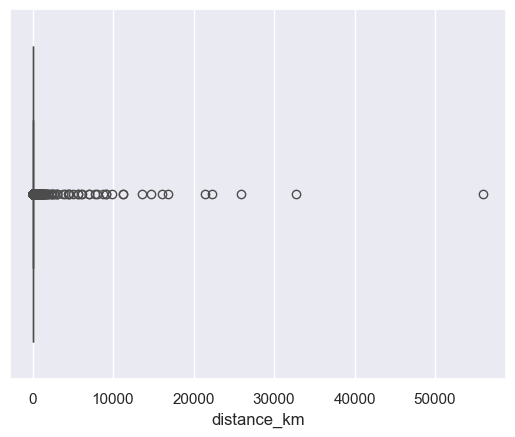

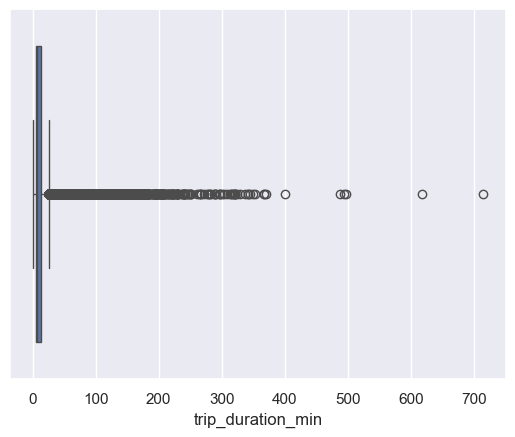

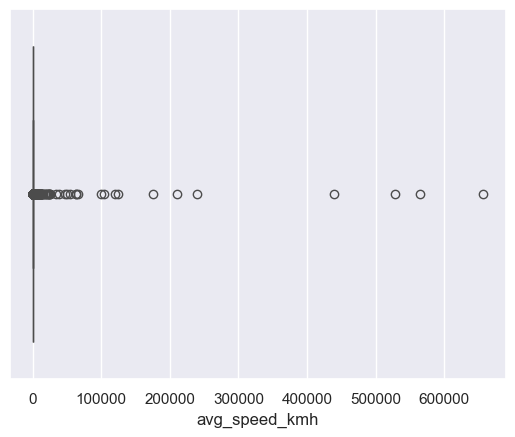

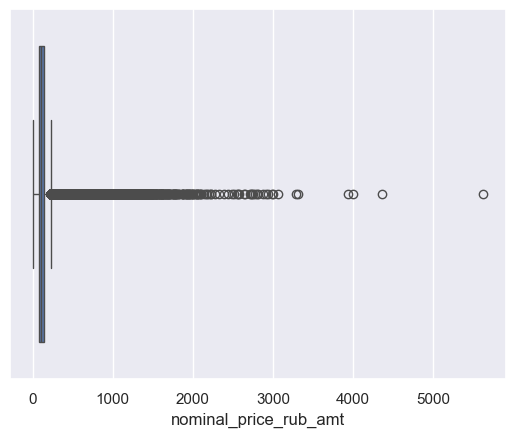

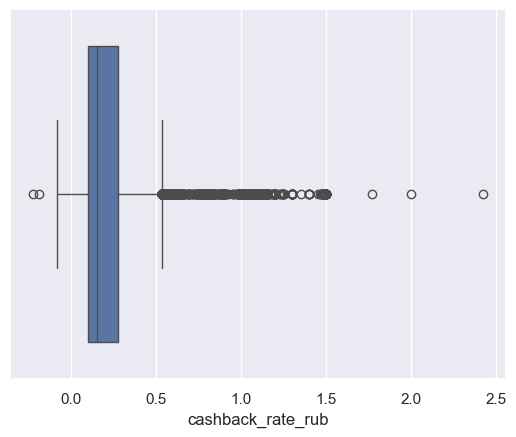

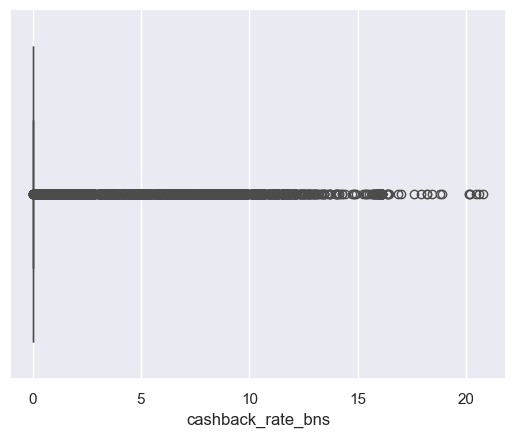

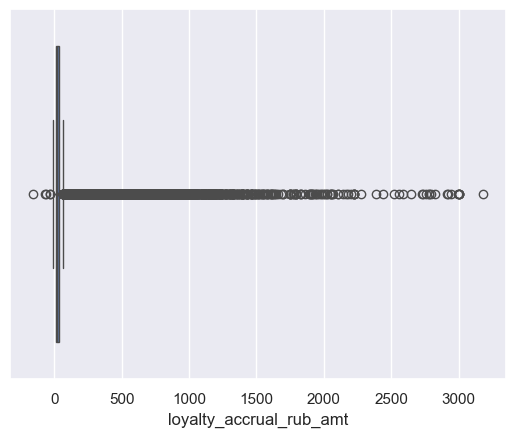

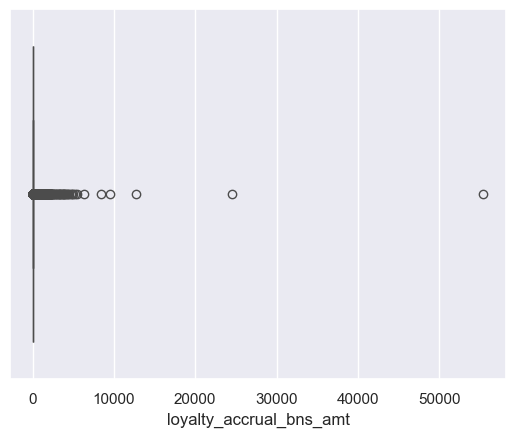

In [38]:
cols = ['distance_km', 'trip_duration_min', 'avg_speed_kmh', 'nominal_price_rub_amt', 'cashback_rate_rub', 'cashback_rate_bns', 'loyalty_accrual_rub_amt', 'loyalty_accrual_bns_amt']

for col in cols:
    sns.boxplot(x = df[col])
    plt.show()

Обнаружены аномалии и выбросы во всех колонках (к примеру, в `distance_km` и `avg_speed_kmh`, скорее всего, из-за сбоя GPS).

При очистке важно учитывать редкие, но возможные случаи, чтобы не удалить валидные наблюдения. Для этого отфильтруем данные по двум критериям: бизнес-логика (отсекаем то, что физически невозможно или противоречит здравому смыслу) и статистический подход (метод перцентилей).

Инициализируем очищенный датасет:

In [39]:
df_clean = df.copy()

Этап 1. Зададим ограничения вручную на основе специфики кикшеринга:

In [40]:
mask_logic = (
        # дистанция от 10 м до 100 км
        (df_clean['distance_km'].between(0.01, 100)) &
        # время поездки от 1 минуты до 4 часов
        (df_clean['trip_duration_min'].between(1, 240)) &
        # средняя скорость от 0.5 до 30 км/ч
        (df_clean['avg_speed_kmh'].between(0.5, 30)) &
        # доля кэшбэка в рублях от 0 до 1 (кэшбэк не может быть больше 100%)
        (df_clean['cashback_rate_rub'].between(0, 1)) &
        # доля кэшбэка в бонусах от 0 до 1
        (df_clean['cashback_rate_bns'].between(0, 1))
)

df_clean = df_clean[mask_logic]
df_clean.head()

,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,transport_model,distance_km,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt,trip_duration_min,avg_speed_kmh,cashback_rate_rub,cashback_rate_bns,hour,day_of_week,month
11,252618395,517007040,M,26,GRD,UNM,Г МОСКВА,7.49,50.0,300.0,SL,0.070,2024-04-17 10:43:29,2024-04-17 10:43:34.133897,2024-04-17 10:45:22.547000,3,2024-04-17 10:43:34.133897,64.98,0.0,0.0,1.807,2.317,0.0,0.0,10,2,4
12,252614779,517007040,M,26,GRD,UNM,Г МОСКВА,7.99,50.0,300.0,SL,0.806,2024-04-17 16:45:16,2024-04-17 16:45:20.641980,2024-04-17 16:51:26.403392,3,2024-04-17 16:45:20.641980,97.94,0.0,0.0,6.096,7.930,0.0,0.0,16,2,4
13,252632694,269139778,F,30,GRD,UNM,Г МОСКВА,7.99,50.0,300.0,SL,0.046,2024-04-17 16:47:59,2024-04-17 16:48:04.538852,2024-04-17 16:49:47.783760,3,2024-04-17 16:48:04.538852,65.98,0.0,0.0,1.721,1.617,0.0,0.0,16,2,4
14,252613575,269139778,F,30,GRD,UNM,Г МОСКВА,7.99,50.0,300.0,SL,0.064,2024-04-17 16:50:58,2024-04-17 16:51:01.965350,2024-04-17 16:52:32.398000,3,2024-04-17 16:51:01.965350,65.98,0.0,0.0,1.507,2.567,0.0,0.0,16,2,4
15,252629528,21817314,F,30,GRD,UNM,МОСКОВСКАЯ ОБЛ,7.49,50.0,300.0,SL,0.055,2024-04-19 10:32:08,2024-04-19 10:32:15.964200,2024-04-19 10:38:11.978319,3,2024-04-19 10:32:15.964200,94.94,0.0,0.0,5.934,0.558,0.0,0.0,10,4,4


Этап 2. Используем 99,9-ый перцентиль, чтобы убрать "хвосты" (удалить верхний 0,1% данных):

In [41]:
columns_to_limit = ['distance_km', 'trip_duration_min', 'avg_speed_kmh', 'nominal_price_rub_amt']

limits = df_clean[columns_to_limit].quantile(0.999)

df_clean = df_clean[
    (df_clean['distance_km'] <= limits['distance_km']) &
    (df_clean['trip_duration_min'] <= limits['trip_duration_min']) &
    (df_clean['avg_speed_kmh'] <= limits['avg_speed_kmh']) &
    (df_clean['nominal_price_rub_amt'] <= limits['nominal_price_rub_amt'])
].reset_index(drop=True)

Посмотрим на распределение очищенных данных:

In [42]:
df_clean.head()

,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,transport_model,distance_km,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt,trip_duration_min,avg_speed_kmh,cashback_rate_rub,cashback_rate_bns,hour,day_of_week,month
0,252618395,517007040,M,26,GRD,UNM,Г МОСКВА,7.49,50.0,300.0,SL,0.070,2024-04-17 10:43:29,2024-04-17 10:43:34.133897,2024-04-17 10:45:22.547000,3,2024-04-17 10:43:34.133897,64.98,0.0,0.0,1.807,2.317,0.0,0.0,10,2,4
1,252614779,517007040,M,26,GRD,UNM,Г МОСКВА,7.99,50.0,300.0,SL,0.806,2024-04-17 16:45:16,2024-04-17 16:45:20.641980,2024-04-17 16:51:26.403392,3,2024-04-17 16:45:20.641980,97.94,0.0,0.0,6.096,7.930,0.0,0.0,16,2,4
2,252632694,269139778,F,30,GRD,UNM,Г МОСКВА,7.99,50.0,300.0,SL,0.046,2024-04-17 16:47:59,2024-04-17 16:48:04.538852,2024-04-17 16:49:47.783760,3,2024-04-17 16:48:04.538852,65.98,0.0,0.0,1.721,1.617,0.0,0.0,16,2,4
3,252613575,269139778,F,30,GRD,UNM,Г МОСКВА,7.99,50.0,300.0,SL,0.064,2024-04-17 16:50:58,2024-04-17 16:51:01.965350,2024-04-17 16:52:32.398000,3,2024-04-17 16:51:01.965350,65.98,0.0,0.0,1.507,2.567,0.0,0.0,16,2,4
4,252629528,21817314,F,30,GRD,UNM,МОСКОВСКАЯ ОБЛ,7.49,50.0,300.0,SL,0.055,2024-04-19 10:32:08,2024-04-19 10:32:15.964200,2024-04-19 10:38:11.978319,3,2024-04-19 10:32:15.964200,94.94,0.0,0.0,5.934,0.558,0.0,0.0,10,4,4


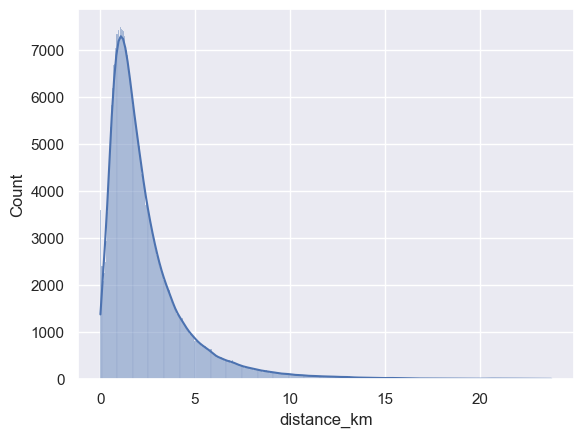

Медиана: 1.7694606573354, среднее: 2.4275446103716747, минимальное: 0.0100232191470226, максимальное: 23.7847127841861


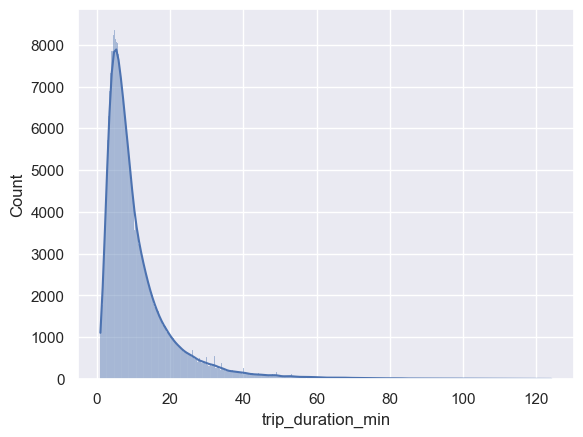

Медиана: 8.03392219543457, среднее: 11.425814628601074, минимальное: 1.0005484819412231, максимальное: 124.10375213623047


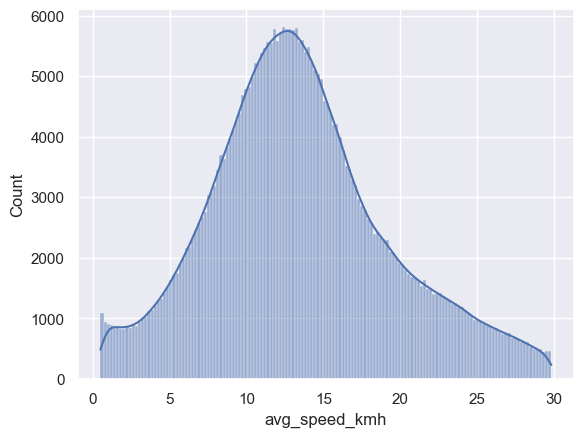

Медиана: 13.02254867553711, среднее: 13.529732704162598, минимальное: 0.5001122951507568, максимальное: 29.824966430664062


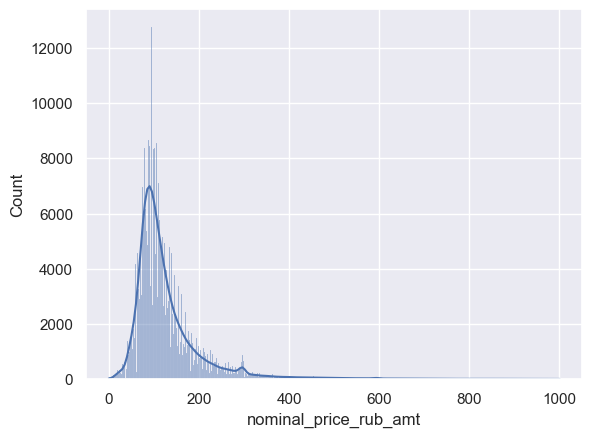

Медиана: 105.92, среднее: 128.09307807118256, минимальное: 0.0, максимальное: 1000.81


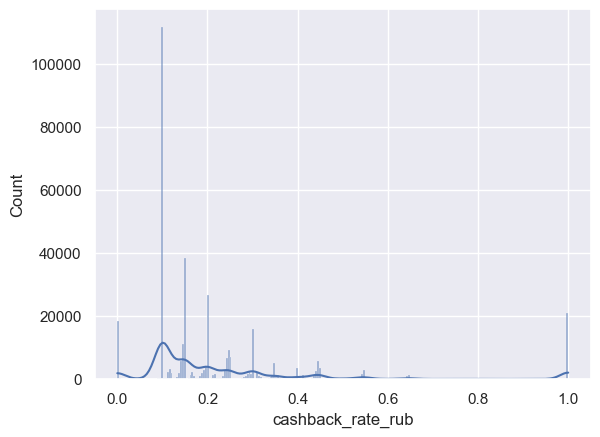

Медиана: 0.14999309182167053, среднее: 0.2316717654466629, минимальное: 0.0, максимальное: 1.0


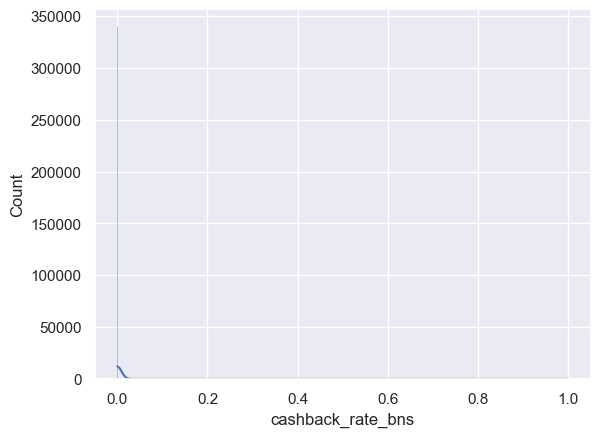

Медиана: 0.0, среднее: 0.024410884827375412, минимальное: 0.0, максимальное: 1.0


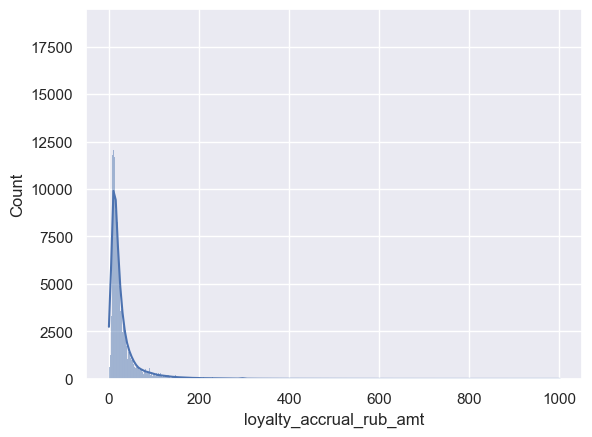

Медиана: 17.58, среднее: 31.91815804121979, минимальное: 0.0, максимальное: 1000.81


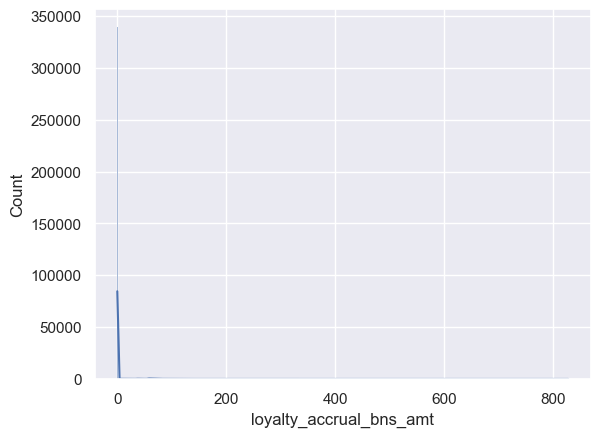

Медиана: 0.0, среднее: 2.8463798659516675, минимальное: 0.0, максимальное: 828.31776


In [43]:
# распределение очищенных данных

cols = ['distance_km', 'trip_duration_min', 'avg_speed_kmh', 'nominal_price_rub_amt', 'cashback_rate_rub', 'cashback_rate_bns', 'loyalty_accrual_rub_amt', 'loyalty_accrual_bns_amt']

for col in cols:
    sns.histplot(df_clean[col], kde=True)
    plt.show()
    print(f'Медиана: {df_clean[col].median()}, среднее: {df_clean[col].mean()}, минимальное: {df_clean[col].min()}, максимальное: {df_clean[col].max()}')

Удалены нереальные значения, сохранены реально редкие случаи.

In [44]:
print(f"Размер очищенного датасета: {df_clean.shape}")

Размер очищенного датасета: (357110, 27)


**Результат:**

- в ходе обработки данных был достигнут баланс между чистотой выборки и сохранением репрезентативности (использование бизнес-логики и порога 99,9% для ключевых признаков);
- удалено около 10% записей, представляющих собой явные технические ошибки;
- финальный объём данных для анализа — **357 тыс.** записей.

---

### Экспорт очищенного датасета

In [45]:
os.makedirs(PATH_CLEAN, exist_ok=True)

df_clean.to_parquet(f"{PATH_CLEAN}/kicksharing_clean.parquet", index=False)
df_clean.to_csv(f"{PATH_CLEAN}/kicksharing_clean.csv", index=False)

print(f"Данные успешно сохранены в папку: {PATH_CLEAN}")

Данные успешно сохранены в папку: ../data/clean


---

### Итоги очистки и подготовки данных

- Данные приведены к корректным типам, что позволило сократить объём потребляемой оперативной памяти на **83%**.
- Пропуски в финансовых метриках заменены на нулевые значения, в категориальных признаках — на категорию `Unknown`.
- Рассчитаны новые признаки: длительность поездки, средняя скорость и доля кэшбэка. Извлечены временные интервалы (час, день недели, месяц) для анализа сезонности.
- Реализована двухэтапная очистка данных от аномалий и выбросов: сначала отсечены физически невозможные значения (бизнес-логика), затем удалены экстремальные выбросы с помощью 99,9-го перцентиля.
- Итоговый объём данных составил **357110 строк** (сохранено **~90%** исходного датасета). Данные очищены от технических сбоев и готовы к исследовательскому анализу (EDA).
- Результат сохранён в форматах `.parquet` (для сохранения типов данных) и `.csv` (для доступности).